In [132]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns

import json

from fycharts.SpotifyCharts import SpotifyCharts
import sqlalchemy

import spotipy
from spotipy.oauth2 import SpotifyClientCredentials

from datetime import datetime
from sklearn.model_selection import train_test_split

import statsmodels.api as sm

# We are required to do this in order to avoid "FutureWarning" issues.
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.arima_model import ARIMA, ARMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller  

from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

%matplotlib inline

import warnings
warnings.simplefilter(action="ignore")

# Reading in data

In [133]:
italy_17_19 = pd.read_pickle('../data/it_17_19_v50_feat.pkl')
spain_17_19 = pd.read_pickle('../data/sp_17_19_v50_feat.pkl')
greece_17_19 = pd.read_pickle('../data/gr_17_19_v50_feat.pkl')

italy_20 = pd.read_pickle('../data/it_20_v50_feat.pkl')
spain_20 = pd.read_pickle('../data/sp_20_v50_feat.pkl')
greece_20 = pd.read_pickle('../data/gr_20_v50_feat.pkl')

In [134]:
spain_20.tail(2)

,Position,Track Name,Artist,region,spotify_id,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
date,,,,,,,,,,,,,,,,,,
2021-02-13,49,La Luz - A COLORS SHOW,María José Llergo,es,5jRnVQbjB6qgN3MARS4xw7,0.722,0.357,9,-10.487,0,0.0996,0.81400,0.155000,0.0863,0.641,149.895,191599,4
2021-02-13,50,Boku no Sensou - TV Size,Shinsei Kamattechan,es,3tRPfCFAEv6wWyQO0YnGGV,0.447,0.891,9,-4.776,1,0.0788,0.00447,0.000905,0.3900,0.517,143.976,90960,4


# Preprocessing data 

#### _Data for each country is split into different dataframes as different combinations and aggregations are needed for different functions._ 

**Resampling by month**

_`rm` denotes resampling by month._ 

In [135]:
rm_italy_17_19 = italy_17_19.resample("M").mean()
rm_spain_17_19 = spain_17_19.resample("M").mean()
rm_greece_17_19 = greece_17_19.resample("M").mean()

rm_italy_20 = italy_20.resample("M").mean()
rm_spain_20 = spain_20.resample("M").mean()
rm_greece_20 = greece_20.resample("M").mean()

**Resampling by week**

_`rw` denotes resampling by week._ 

In [136]:
rw_italy_17_19 = italy_17_19.resample("W").mean()
rw_spain_17_19 = spain_17_19.resample("W").mean()
rw_greece_17_19 = greece_17_19.resample("W").mean()

rw_italy_20 = italy_20.resample("W").mean()
rw_spain_20 = spain_20.resample("W").mean()
rw_greece_20 = greece_20.resample("W").mean()

#### Combining weekly resampled data for all years (2017-2020)

In [137]:
alltime_italy = pd.concat([italy_17_19, italy_20])
alltime_spain = pd.concat([spain_17_19, spain_20])
alltime_greece = pd.concat([greece_17_19, greece_20])

alltime_rw_italy = alltime_italy.resample("W").mean()
alltime_rw_spain = alltime_spain.resample("W").mean()
alltime_rw_greece = alltime_greece.resample("W").mean()

#### Splitting into dataframes for each year! 

In [138]:
it_rw_17 = alltime_rw_italy[0:53]
it_rw_18 = alltime_rw_italy[53:105]
it_rw_19 = alltime_rw_italy[105:158]

In [139]:
it_rw_18.tail(2)

,Position,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
date,,,,,,,,,,,,,,
2018-12-23,25.5,0.652526,0.62446,5.345714,-7.126363,0.548571,0.098575,0.315516,0.058491,0.126928,0.464983,117.940511,209852.965714,3.985714
2018-12-30,25.5,0.637171,0.63514,4.971429,-6.814571,0.528571,0.104640,0.342631,0.066215,0.139117,0.460786,121.689883,216545.840000,3.934286


# Differencing Data for Stationarity

### Augmented Dickey-Fuller test to estimate whether data are stationary. 

In [140]:
audio_features = [
'danceability', 
 'energy',
 'key',
 'loudness',
 'mode',
 'speechiness',
 'acousticness',
 'instrumentalness',
 'liveness',
 'valence',
 'tempo']

In [141]:
# Code by Joseph Nelson! 

def interpret_dftest(dftest):
    dfoutput = pd.Series(dftest[0:3], index=['Test Statistic', 'p-value', 'lags_used'])
    return dfoutput

_Dickey-Fuller on original dataframes_

In [142]:
for feature in audio_features:
    print(f'Dickey-Fuller Interpretation for {feature}:\n{interpret_dftest(adfuller(it_rw_18[feature]))}')

Dickey-Fuller Interpretation for danceability:
Test Statistic   -2.978150
p-value           0.036986
lags_used         1.000000
dtype: float64
Dickey-Fuller Interpretation for energy:
Test Statistic   -3.24877
p-value           0.01733
lags_used         0.00000
dtype: float64
Dickey-Fuller Interpretation for key:
Test Statistic   -3.469608
p-value           0.008803
lags_used         4.000000
dtype: float64
Dickey-Fuller Interpretation for loudness:
Test Statistic   -3.003203
p-value           0.034596
lags_used         0.000000
dtype: float64
Dickey-Fuller Interpretation for mode:
Test Statistic   -4.432011
p-value           0.000260
lags_used         0.000000
dtype: float64
Dickey-Fuller Interpretation for speechiness:
Test Statistic    -1.736793
p-value            0.412262
lags_used         10.000000
dtype: float64
Dickey-Fuller Interpretation for acousticness:
Test Statistic   -2.390354
p-value           0.144477
lags_used         0.000000
dtype: float64
Dickey-Fuller Interpretatio

### DataFrame with once-differenced data

In [143]:
lag_df_italy = alltime_rw_italy.copy()

In [144]:
for feature in audio_features: 
    lag_df_italy[f'{feature}_once_differenced'] = lag_df_italy[feature].diff(1).fillna(0)

In [145]:
lag_df_italy.tail(2)

,Position,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,...,energy_once_differenced,key_once_differenced,loudness_once_differenced,mode_once_differenced,speechiness_once_differenced,acousticness_once_differenced,instrumentalness_once_differenced,liveness_once_differenced,valence_once_differenced,tempo_once_differenced
date,,,,,,,,,,,,,,,,,,,,,
2021-02-07,25.5,0.666561,0.634389,5.402857,-6.677991,0.680000,0.109192,0.268234,0.035348,0.223654,...,0.029374,0.18000,0.314663,0.031429,-0.001159,-0.073344,-0.001695,0.005719,-0.006398,3.285271
2021-02-14,25.5,0.671104,0.647343,5.516667,-6.842603,0.656667,0.120716,0.277941,0.054173,0.220087,...,0.012955,0.11381,-0.164612,-0.023333,0.011523,0.009707,0.018826,-0.003567,0.049983,1.041837


_Dickey-Fuller on lag dataframe_

In [146]:
for feature in audio_features:
    print(f'Dickey-Fuller Interpretation for {feature}, once-differenced:\n{interpret_dftest(adfuller(lag_df_italy[feature].diff(1).fillna(0)))}')

Dickey-Fuller Interpretation for danceability, once-differenced:
Test Statistic   -9.142255e+00
p-value           2.828632e-15
lags_used         5.000000e+00
dtype: float64
Dickey-Fuller Interpretation for energy, once-differenced:
Test Statistic   -6.782611e+00
p-value           2.477455e-09
lags_used         7.000000e+00
dtype: float64
Dickey-Fuller Interpretation for key, once-differenced:
Test Statistic   -8.518281e+00
p-value           1.118537e-13
lags_used         7.000000e+00
dtype: float64
Dickey-Fuller Interpretation for loudness, once-differenced:
Test Statistic   -7.002232e+00
p-value           7.272028e-10
lags_used         6.000000e+00
dtype: float64
Dickey-Fuller Interpretation for mode, once-differenced:
Test Statistic   -9.845662e+00
p-value           4.627101e-17
lags_used         4.000000e+00
dtype: float64
Dickey-Fuller Interpretation for speechiness, once-differenced:
Test Statistic   -8.291616e+00
p-value           4.246658e-13
lags_used         5.000000e+00
dtype

_Checking that these are the same_

In [147]:
interpret_dftest(adfuller(lag_df_italy['energy_once_differenced']))

Test Statistic   -6.782611e+00
p-value           2.477455e-09
lags_used         7.000000e+00
dtype: float64

In [148]:
interpret_dftest(adfuller(lag_df_italy['energy'].diff(1).fillna(0)))

Test Statistic   -6.782611e+00
p-value           2.477455e-09
lags_used         7.000000e+00
dtype: float64

### Using `ndiffs` to figure out how many orders of difference $d$ I need in oder to have stationarity

#### _Running `ndiff` and `p,d,q` functions just on 2018 Italy data instead of alltime Italy data; however I will just be checking it out; will leave the `ndiff_dict` and `ndiff_df` as is because that is use in models. Will use 2018 data to build the `ndiff_df` to see if this yields better results for this year._ 

In [149]:
from pmdarima.arima.utils import ndiffs

In [150]:
for feature in audio_features:
    print(f'ndiffs for {feature} stationarity w/ adf test: {ndiffs(alltime_rw_italy[feature], test= "adf")}')

ndiffs for danceability stationarity w/ adf test: 1
ndiffs for energy stationarity w/ adf test: 0
ndiffs for key stationarity w/ adf test: 0
ndiffs for loudness stationarity w/ adf test: 0
ndiffs for mode stationarity w/ adf test: 1
ndiffs for speechiness stationarity w/ adf test: 0
ndiffs for acousticness stationarity w/ adf test: 0
ndiffs for instrumentalness stationarity w/ adf test: 0
ndiffs for liveness stationarity w/ adf test: 0
ndiffs for valence stationarity w/ adf test: 0
ndiffs for tempo stationarity w/ adf test: 0


In [151]:
for feature in audio_features:
    print(f'ndiffs for {feature} stationarity w/ adf test: {ndiffs(it_rw_18[feature], test= "adf")}')

ndiffs for danceability stationarity w/ adf test: 1
ndiffs for energy stationarity w/ adf test: 1
ndiffs for key stationarity w/ adf test: 1
ndiffs for loudness stationarity w/ adf test: 1
ndiffs for mode stationarity w/ adf test: 1
ndiffs for speechiness stationarity w/ adf test: 1
ndiffs for acousticness stationarity w/ adf test: 1
ndiffs for instrumentalness stationarity w/ adf test: 1
ndiffs for liveness stationarity w/ adf test: 1
ndiffs for valence stationarity w/ adf test: 1
ndiffs for tempo stationarity w/ adf test: 1


In [152]:
for feature in audio_features:
    print(f'ndiffs for {feature} stationarity w/ kpss test: {ndiffs(alltime_rw_italy[feature])}')

ndiffs for danceability stationarity w/ kpss test: 1
ndiffs for energy stationarity w/ kpss test: 1
ndiffs for key stationarity w/ kpss test: 0
ndiffs for loudness stationarity w/ kpss test: 0
ndiffs for mode stationarity w/ kpss test: 0
ndiffs for speechiness stationarity w/ kpss test: 1
ndiffs for acousticness stationarity w/ kpss test: 1
ndiffs for instrumentalness stationarity w/ kpss test: 1
ndiffs for liveness stationarity w/ kpss test: 1
ndiffs for valence stationarity w/ kpss test: 1
ndiffs for tempo stationarity w/ kpss test: 0


In [153]:
for feature in audio_features:
    print(f'ndiffs for {feature} stationarity w/ kpss test: {ndiffs(it_rw_18[feature])}')

ndiffs for danceability stationarity w/ kpss test: 1
ndiffs for energy stationarity w/ kpss test: 0
ndiffs for key stationarity w/ kpss test: 0
ndiffs for loudness stationarity w/ kpss test: 0
ndiffs for mode stationarity w/ kpss test: 0
ndiffs for speechiness stationarity w/ kpss test: 0
ndiffs for acousticness stationarity w/ kpss test: 1
ndiffs for instrumentalness stationarity w/ kpss test: 1
ndiffs for liveness stationarity w/ kpss test: 1
ndiffs for valence stationarity w/ kpss test: 0
ndiffs for tempo stationarity w/ kpss test: 0


### Finding `p`, `d`, and `q` values

_Using only the five audio features that are the most relevant or show some sort of pattern_ 

In [154]:
five_features = ['danceability', 'mode', 'acousticness', 'valence', 'energy']

_Building dataframe with `ndifffs` for stationarity for each feature_

_This time using `it_rw_18` instead of `alltime_rw_italy`._

In [155]:
ndiff_dict = {
    'audio_feature':[],
    'ndiffs for stationarity':[]    
}

for feature in five_features:
    ndiff_dict['audio_feature'].append(feature)
    ndiff_dict['ndiffs for stationarity'].append(ndiffs(it_rw_18[feature], test= "adf"))

ndiff_df = pd.DataFrame(ndiff_dict)
ndiff_df

,audio_feature,ndiffs for stationarity
0,danceability,1
1,mode,1
2,acousticness,1
3,valence,1
4,energy,1


In [156]:
arima_dict_18 = {
    'audio_feature':[],
    'ndiffs(d)':[],
    'best_p':[],
    'best_q':[],
    'order':[],
    'ARIMA_model':[],
    'ARIMA_AIC':[]
}

def find_p_and_q(df, feature, arima_dict, n=6):
    
    train = df[feature][0:162]
    
    d = ndiff_df.loc[ndiff_df['audio_feature'] == feature, 'ndiffs for stationarity'].iloc[0]

    # starting with large start AIC
    best_aic = 99 * (10 * 16)
    # creating variables to store best values ofd p and q 
    best_p = 0
    best_q = 0 

    # use nested for loop to iterate over values of p and q
    for p in range(n):

        for q in range(n):

            # insert try and and except statements
            try: 

                # fitting on ARIMA(p, 1, q) model 
                print(f'Attempting to fit ARIMA({p}, {d}, {q})')

                # instantiate ARIMA model
                arima = ARIMA(train, order=(p,d,q))

                # fit ARIMA model 
                model = arima.fit()

                # print out AIC for ARIMA(p, 1, q) model 
                print(f'For {feature}, the AIC for ARIMA({p},{d},{q}) is: {model.aic}')

                # Is this current model's AIC better than the OF best_aic? 
                if model.aic < best_aic:
                    # we want aic to be lower so we are setting a high aic and hoping for something lower 

                    # if it is, we overwrite the best_aic, best_p, and best_q
                    best_aic = model.aic
                    best_p = p 
                    best_q = q

            except:
                pass 

        order = (best_p, d, best_q)
    
    arima_dict['audio_feature'].append(feature)
    arima_dict['ndiffs(d)'].append(d)
    arima_dict['best_p'].append(best_p)
    arima_dict['best_q'].append(best_q)
    arima_dict['order'].append(order)
    arima_dict['ARIMA_model'].append(f'ARIMA({best_p},{d},{best_q})')
    arima_dict['ARIMA_AIC'].append(best_aic)

    print()
    print(f'{feature.upper()} MODEL FINISHED!')
    print(f'The model for {feature} that minimizes AIC on the training data is the ARIMA({best_p},{d},{best_q}).')
    print(f'The model has an aIC of {best_aic}.')
    print()

In [157]:
arima_dict_18

{'audio_feature': [],
 'ndiffs(d)': [],
 'best_p': [],
 'best_q': [],
 'order': [],
 'ARIMA_model': [],
 'ARIMA_AIC': []}

In [158]:
for feature in five_features:
    find_p_and_q(it_rw_18, feature, arima_dict_18)

Attempting to fit ARIMA(0, 1, 0)
For danceability, the AIC for ARIMA(0,1,0) is: -208.1953537460845
Attempting to fit ARIMA(0, 1, 1)
For danceability, the AIC for ARIMA(0,1,1) is: -217.46053918380267
Attempting to fit ARIMA(0, 1, 2)
For danceability, the AIC for ARIMA(0,1,2) is: -215.5403946382255
Attempting to fit ARIMA(0, 1, 3)
For danceability, the AIC for ARIMA(0,1,3) is: -213.59537392598708
Attempting to fit ARIMA(0, 1, 4)
For danceability, the AIC for ARIMA(0,1,4) is: -211.7479708394353
Attempting to fit ARIMA(0, 1, 5)
For danceability, the AIC for ARIMA(0,1,5) is: -209.95290478242964
Attempting to fit ARIMA(1, 1, 0)
For danceability, the AIC for ARIMA(1,1,0) is: -216.14528638421535
Attempting to fit ARIMA(1, 1, 1)
For danceability, the AIC for ARIMA(1,1,1) is: -215.54781502403603
Attempting to fit ARIMA(1, 1, 2)
For danceability, the AIC for ARIMA(1,1,2) is: -213.54938129555666
Attempting to fit ARIMA(1, 1, 3)
Attempting to fit ARIMA(1, 1, 4)
Attempting to fit ARIMA(1, 1, 5)
Atte

In [159]:
arima_param_df_18 = pd.DataFrame(arima_dict_18)
arima_param_df_18

,audio_feature,ndiffs(d),best_p,best_q,order,ARIMA_model,ARIMA_AIC
0,danceability,1,0,1,"(0, 1, 1)","ARIMA(0,1,1)",-217.460539
1,mode,1,3,0,"(3, 1, 0)","ARIMA(3,1,0)",-146.889516
2,acousticness,1,0,2,"(0, 1, 2)","ARIMA(0,1,2)",-184.369110
3,valence,1,2,4,"(2, 1, 4)","ARIMA(2,1,4)",-191.967291
4,energy,1,0,0,"(0, 1, 0)","ARIMA(0,1,0)",-212.768422


# ARIMA Models  

### Function to create, evaluate, and plot `ARIMA` models 

In [160]:
def arima_predict_plot(df, feature, year, param_df, title='title', figsize=(15,5), order=None, d=None, ci=True):
  
    # create train and test sets
    n_rows = round(len(df)*0.9)
    train = df[feature][0:n_rows]
    test = df[feature][n_rows:]
    
    # find ndiffs for stationarity from ndiff dataframe
    if d is None: 
        d = ndiff_df.loc[ndiff_df['audio_feature'] == feature, 'ndiffs for stationarity'].iloc[0]
    print(f'd = {d}')
    
    if order is None:
        # find order from arima parameters dataframe 
        order = param_df.loc[param_df['audio_feature'] == feature, 'order'].iloc[0]
    print(f'order = {order}')
   
    try: 
        # instantiate ARIMA model
        model = ARIMA(train, order=order)

        # fit ARIMA model
        arima = model.fit()

        # get predictions for train and test sets 
        preds_train = model.predict(params=arima.params, start=train.index[d], end=train.index[-1], typ='levels')
        preds_test = model.predict(params=arima.params, start=test.index[0], end=test.index[-1], typ='levels')

        # calculate and print RMSE for train and test setes 
        train_rmse = mean_squared_error(train[d::], preds_train)**0.5
        print(f'{feature.capitalize()} train RMSE ({year}) - ARIMA({order}): {train_rmse}')

        test_rmse = mean_squared_error(test, preds_test)**0.5
        print(f'{feature.capitalize()} test RMSE ({year}) - ARIMA({order}): {test_rmse}')

        # add RMSEs to arima parameters dataframe 
        param_df.loc[param_df['audio_feature'] == feature, 'arima_train_rmse'] = train_rmse    
        param_df.loc[param_df['audio_feature'] == feature, 'arima_test_rmse'] = test_rmse

          # set up plot
        plt.figure(figsize=figsize)

        # plot training data 
        plt.plot(train, color='blue')

        # plot testing data 
        plt.plot(test.index, test, color='orange')

        # plot predicted values for test set 
        plt.plot(test.index, preds_test, color='green')

        # add line for the baseline model (mean value of feature)
        plt.hlines(df[feature].mean(), train.index[0], test.index[-1], color = 'grey')

        # plot confidence interval
        if ci:
            ci = 1.96 * np.std(preds_test)/np.mean(preds_test)
            plt.fill_between(test.index, (preds_test - ci), (preds_test + ci), color='blue', alpha=.1) 

        # make plot with title! 
        plt.title(title, fontsize=16)
        plt.show() ; 
        
    except:
        print(ValueError)
        pass

_Function soley for plotting to be used when needed._

In [161]:
def arima_plot(train, test, preds_test, title='title', figsize=(15,5), ci=True):
    
    # set up plot
    plt.figure(figsize=figsize)
    
    # plot training data 
    plt.plot(train, color='blue')
    
    # plot testing data 
    plt.plot(test.index, test, color='orange')
    
    # plot predicted values for test set 
    plt.plot(test.index, preds_test, color='green')
    
    # add line for the baseline model (mean value of feature)
    # plt.hlines(df[feature].mean(), train.index[0], test.index[-1], color = 'grey')
    
    # plot confidence interval 
    if ci:
        ci = 1.96 * np.std(preds_test)/np.mean(preds_test)
        plt.fill_between(test.index, (preds_test - ci), (preds_test + ci), color='blue', alpha=.1) 
    
    # make plot with title! 
    plt.title(title, fontsize=16)
    plt.show() ; 

### ARIMA Models - 2018

_Using `arima_predict_plot` function to run ARIMA model for each feature and show plot of actual vs. test._

_This will also add columns for `arima_train_rmse` and `arima_test_rmse`._

In [162]:
it_rw_18.head(2)

,Position,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
date,,,,,,,,,,,,,,
2018-01-07,25.5,0.585277,0.553841,5.585714,-8.274331,0.722857,0.095949,0.327071,0.035985,0.160532,0.430290,114.93042,213619.057143,3.911429
2018-01-14,25.5,0.572549,0.554074,4.854286,-8.483963,0.662857,0.082705,0.292300,0.025686,0.148855,0.441377,114.26098,210318.791429,3.962857


In [163]:
it_rw_18.tail(2)

,Position,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
date,,,,,,,,,,,,,,
2018-12-23,25.5,0.652526,0.62446,5.345714,-7.126363,0.548571,0.098575,0.315516,0.058491,0.126928,0.464983,117.940511,209852.965714,3.985714
2018-12-30,25.5,0.637171,0.63514,4.971429,-6.814571,0.528571,0.104640,0.342631,0.066215,0.139117,0.460786,121.689883,216545.840000,3.934286


d = 1
order = (0, 1, 1)
Danceability train RMSE (2018) - ARIMA((0, 1, 1)): 0.028160797322810252
Danceability test RMSE (2018) - ARIMA((0, 1, 1)): 0.010787127076728645


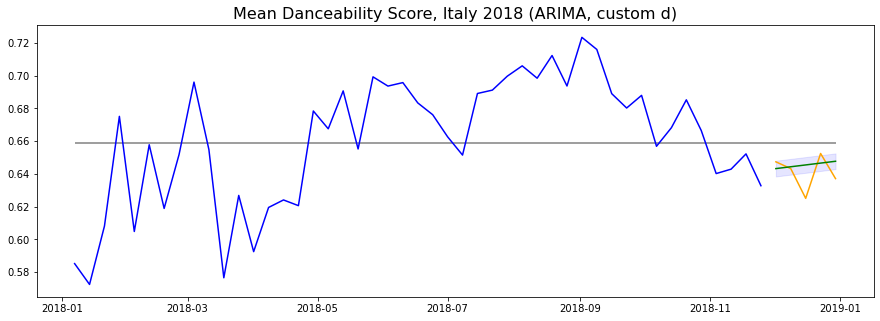

d = 1
order = (3, 1, 0)
Mode train RMSE (2018) - ARIMA((3, 1, 0)): 0.05356106305997141
Mode test RMSE (2018) - ARIMA((3, 1, 0)): 0.04275150664738172


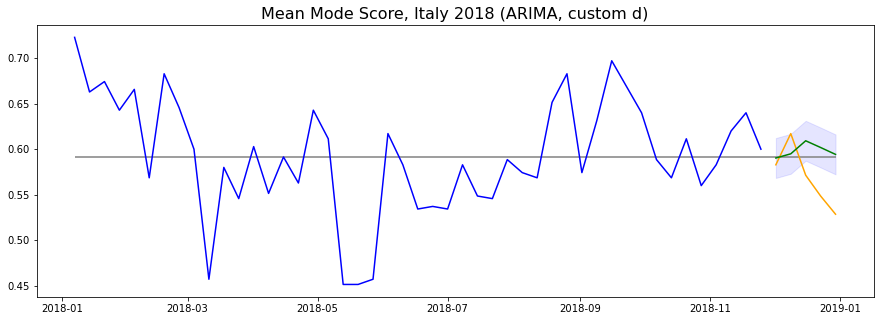

d = 1
order = (0, 1, 2)
Acousticness train RMSE (2018) - ARIMA((0, 1, 2)): 0.03635108301796731
Acousticness test RMSE (2018) - ARIMA((0, 1, 2)): 0.05726829580318497


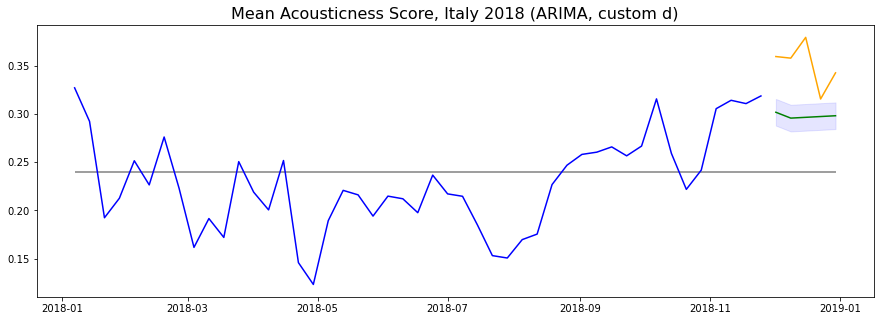

d = 1
order = (2, 1, 4)
<class 'ValueError'>
d = 1
order = (0, 1, 0)
Energy train RMSE (2018) - ARIMA((0, 1, 0)): 0.02966990247762252
Energy test RMSE (2018) - ARIMA((0, 1, 0)): 0.01984754737372488


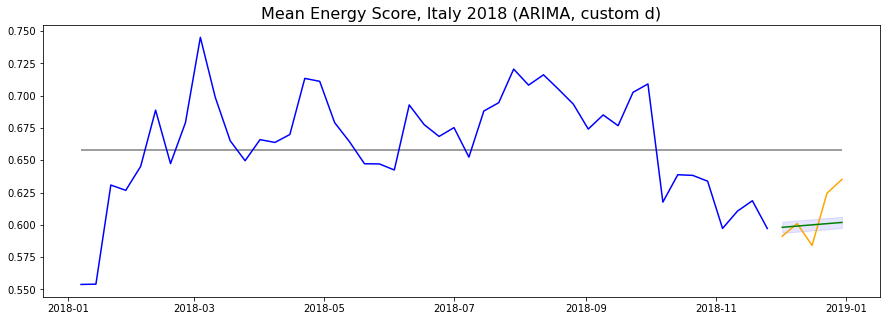

In [164]:
for feature in five_features: 
    arima_predict_plot(it_rw_18, feature, 2018, arima_param_df_18, title=f'Mean {feature.capitalize()} Score, Italy 2018 (ARIMA, custom d)')

_redoing valence because the AR/MA coefficients needed to be changed_

d = 1
order = (2, 1, 2)
Valence train RMSE (2018) - ARIMA((2, 1, 2)): 0.035609520861555256
Valence test RMSE (2018) - ARIMA((2, 1, 2)): 0.04809084411253774


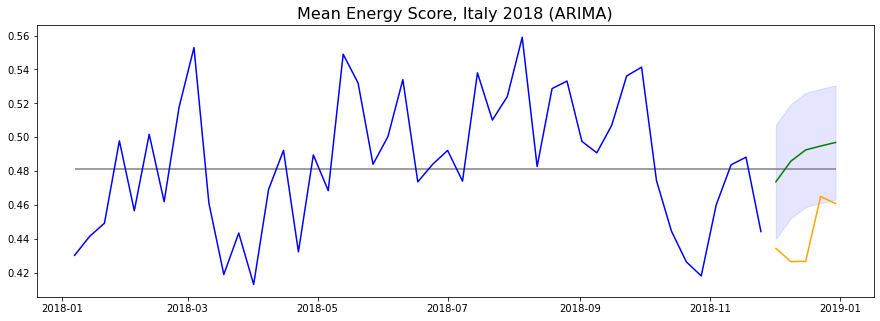

In [165]:
arima_predict_plot(it_rw_18, 'valence', 2018, arima_param_df_18, title=f'Mean {feature.capitalize()} Score, Italy 2018 (ARIMA)', order=(2,1,2,), d=1)

#### _Updated `arima_param_df_18`_

In [166]:
arima_param_df_18

,audio_feature,ndiffs(d),best_p,best_q,order,ARIMA_model,ARIMA_AIC,arima_train_rmse,arima_test_rmse
0,danceability,1,0,1,"(0, 1, 1)","ARIMA(0,1,1)",-217.460539,0.028161,0.010787
1,mode,1,3,0,"(3, 1, 0)","ARIMA(3,1,0)",-146.889516,0.053561,0.042752
2,acousticness,1,0,2,"(0, 1, 2)","ARIMA(0,1,2)",-184.369110,0.036351,0.057268
3,valence,1,2,4,"(2, 1, 4)","ARIMA(2,1,4)",-191.967291,0.035610,0.048091
4,energy,1,0,0,"(0, 1, 0)","ARIMA(0,1,0)",-212.768422,0.029670,0.019848


# SARIMAX models 

In [167]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

#### _As baseline, Fitting SARIMAX with `seasonal_order = (2, 0, 2, 52)` and no exogenous variables before incorporating/engineering those components._

RMSE = 0.02


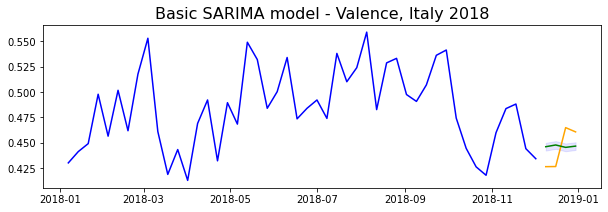

In [168]:
P, D, Q, S = 2, 0 ,2, 52
train_val = it_rw_18['valence'][0:48]
test_val = it_rw_18['valence'][48:]

sarima_val = SARIMAX(endog = train_val, order = (2, 0, 2), seasonal_order = (P, D, Q, S)).fit()
# sarima_pred = sarima.predict(start=start, end = end)

preds_train_sarima_val = sarima_val.predict(start=train_val.index[0], end=train_val.index[-1])
preds_test_sarima_val = sarima_val.predict(start=test_val.index[0], end=test_val.index[-1])

print(f'RMSE = {round(mean_squared_error(test_val, preds_test_sarima_val)**.5, 2)}')

arima_plot(train_val, test_val, preds_test_sarima_val, title="Basic SARIMA model - Valence, Italy 2018", figsize=(10,3))

#### Plotting ARIMA plot from above again, for comparison: 

d = 1
order = (2, 1, 2)
Valence train RMSE (2018) - ARIMA((2, 1, 2)): 0.036157040161561356
Valence test RMSE (2018) - ARIMA((2, 1, 2)): 0.04017210751841029


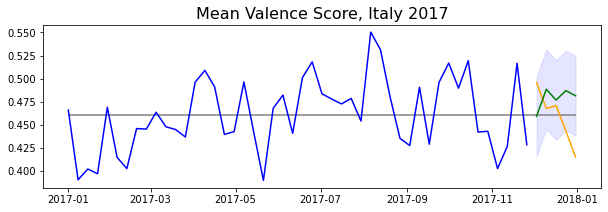

In [169]:
arima_predict_plot(it_rw_17, 'valence', 2018, arima_param_df_18, title=f'Mean Valence Score, Italy 2017', figsize=(10,3), order=(2,1,2))

### SARIMAX Seasonal Parameters

#### _Grid search to find best `P`, `D`, `Q`, and `s` values_

In [170]:
def find_sarima_parameters(df, feature, param_df, n_rows=47):    
    
    import time
    t0 = time.time()
    final_mae = 1000000000000
    final_S = 0
    final_D = 0
    final_P = 0
    final_Q = 0
    
    # find order from arima parameters dataframe 
    order = param_df.loc[param_df['audio_feature'] == feature, 'order'].iloc[0]

    train_values = df[feature][0:n_rows]
    test_values = df[feature][n_rows:]

    for S in range(48,53):
        for D in range(2):
            for P in range(4):
                for Q in range(4):
                    print(f'Checking ({P}, {D}, {Q}, {S}) at {round(time.time() - t0)} seconds.')
                    try:
                        sarima = SARIMAX(endog = train_values,
                                         order = order,
                                         seasonal_order = (P, D, Q, S)).fit()

                        sarima_pred = sarima.predict(start=test_values.index[0], end=test_values.index[-1], typ='levels')

                        if mean_absolute_error(test_values, sarima_pred) < final_mae:
                            final_mae = mean_absolute_error(test_values, sarima_pred)
                            final_S = S
                            final_D = D
                            final_P = P
                            final_Q = Q

                        print(f'We just fit a SARIMAX(2, 0, 2)x({P}, {D}, {Q}, {S}) model with {mean_absolute_error(test_values, sarima_pred)} MAE and {mean_squared_error(test_values, sarima_pred)**0.5} RMSE.')

                    except:
                        print('problem!')
                        raise

    print()
    print(f'The final model for {feature} is SARIMAX(2, 0, 2)x({final_P}, {final_D}, {final_Q}, {final_S}).')
    print()

In [171]:
five_features

['danceability', 'mode', 'acousticness', 'valence', 'energy']

In [172]:
# for feature in five_features: 
#     find_sarima_parameters(it_rw_18, feature, arima_param_df_18)

Because of `linalgerror` while trying to run `find_sarima_parameters` on 2018 Italy data (`it_rw_18`) I will use the same `seasonal_order` for each the audio as was determined by the 2017 data (`it_rw_18`). 

Results from above for 2017 data:
+ The final model for danceability is SARIMAX(2, 0, 2)x(3, 0, 0, 48).
+ The final model for mode is SARIMAX(2, 0, 2)x(1, 0, 1, 52).
+ The final model for acousticness is SARIMAX(2, 0, 2)x(1, 0, 2, 48).
+ The final model for valence is SARIMAX(2, 0, 2)x(0, 0, 1, 49).
+ The final model for energy is SARIMAX(2, 0, 2)x(2, 0, 0, 49).

Results from SARIMA seasonal order grid search using 2017-2020 data:

+ The final model for danceability is SARIMAX(2, 0, 2)x(2, 0, 3, 48).
+ The final model for mode is SARIMAX(2, 0, 2)x(0, 0, 0, 48).
+ The final model for acousticness is SARIMAX(2, 0, 2)x(0, 1, 0, 48).
+ The final model for valence is SARIMAX(2, 0, 2)x(1, 0, 3, 50).
+ The final model for energy is SARIMAX(2, 0, 2)x(0, 0, 2, 51).

#### _Adding Seasonal Orders to `param_df`_

citation: converting string to tuple https://www.geeksforgeeks.org/python-convert-string-to-tuple/

In [173]:
arima_param_df_18.loc[arima_param_df_18['audio_feature'] == 'danceability', 'seasonal_order'] = '3, 0, 0, 48'
arima_param_df_18.loc[arima_param_df_18['audio_feature'] == 'mode', 'seasonal_order'] = '1, 0, 1, 52'
arima_param_df_18.loc[arima_param_df_18['audio_feature'] == 'acousticness', 'seasonal_order'] = '1, 0, 2, 48'
arima_param_df_18.loc[arima_param_df_18['audio_feature'] == 'valence', 'seasonal_order'] = '0, 0, 1, 49'
arima_param_df_18.loc[arima_param_df_18['audio_feature'] == 'energy', 'seasonal_order'] = '2, 0, 0, 49'

In [174]:
arima_param_df_18.loc[arima_param_df_18['audio_feature'] == 'danceability', 'seasonal_order_all_data'] = '2, 0, 3, 48'
arima_param_df_18.loc[arima_param_df_18['audio_feature'] == 'mode', 'seasonal_order_all_data'] = '0, 0, 0, 48'
arima_param_df_18.loc[arima_param_df_18['audio_feature'] == 'acousticness', 'seasonal_order_all_data'] = '0, 1, 0, 48'
arima_param_df_18.loc[arima_param_df_18['audio_feature'] == 'valence', 'seasonal_order_all_data'] = '1, 0, 3, 50'
arima_param_df_18.loc[arima_param_df_18['audio_feature'] == 'energy', 'seasonal_order_all_data'] = '0, 0, 2, 51'

#### _Updated `arima_param_df_18`_

In [175]:
arima_param_df_18

,audio_feature,ndiffs(d),best_p,best_q,order,ARIMA_model,ARIMA_AIC,arima_train_rmse,arima_test_rmse,seasonal_order,seasonal_order_all_data
0,danceability,1,0,1,"(0, 1, 1)","ARIMA(0,1,1)",-217.460539,0.028161,0.010787,"3, 0, 0, 48","2, 0, 3, 48"
1,mode,1,3,0,"(3, 1, 0)","ARIMA(3,1,0)",-146.889516,0.053561,0.042752,"1, 0, 1, 52","0, 0, 0, 48"
2,acousticness,1,0,2,"(0, 1, 2)","ARIMA(0,1,2)",-184.369110,0.036351,0.057268,"1, 0, 2, 48","0, 1, 0, 48"
3,valence,1,2,4,"(2, 1, 4)","ARIMA(2,1,4)",-191.967291,0.036157,0.040172,"0, 0, 1, 49","1, 0, 3, 50"
4,energy,1,0,0,"(0, 1, 0)","ARIMA(0,1,0)",-212.768422,0.029670,0.019848,"2, 0, 0, 49","0, 0, 2, 51"


#### _Function for SARIMA w/ seasonal components, no exogenous variables:_

In [176]:
def sarima_predict_plot_seasonal(df, feature, year, param_df, title='title', figsize=(15,5), order=None, d=None, seasonal_order=None, ci=True):
  
    # create train and test sets
    n_rows = round(len(df)*0.9)
    train = df[feature][0:n_rows]
    test = df[feature][n_rows:]
    
    # find ndiffs for stationarity from ndiff dataframe
    if d is None: 
        d = ndiff_df.loc[ndiff_df['audio_feature'] == feature, 'ndiffs for stationarity'].iloc[0]
    print(f'd = {d}')
    
    # find order from arima parameters dataframe 
    if order is None:
        order = param_df.loc[param_df['audio_feature'] == feature, 'order'].iloc[0]
    print(f'order = {order}')
    
    # find seasonal order from arima parameters dataframe 
    if seasonal_order is None: 
        sea_string = param_df.loc[param_df['audio_feature'] == feature, 'seasonal_order'].iloc[0]
        seasonal_order = tuple(map(int, sea_string.split(', '))) 
    print(f'seasonal order = {seasonal_order}')
    
    try: 

        # instantiate and fit SARIMAX model 
        sarima = SARIMAX(endog=train, order=order, seasonal_order=seasonal_order).fit()

        # get predictions for train and test sets 
        preds_train = sarima.predict(start=train.index[d], end=train.index[-1], typ='levels')
        preds_test = sarima.predict(start=test.index[0], end=test.index[-1], typ='levels')

        # calculate and print RMSE for train and test setes 
        train_rmse = mean_squared_error(train[d::], preds_train)**0.5
        print(f'{feature.capitalize()} train RMSE ({year}) - SARIMA({order}): {train_rmse}')

        test_rmse = mean_squared_error(test, preds_test)**0.5
        print(f'{feature.capitalize()} test RMSE ({year}) - SARIMA({order}): {test_rmse}')    

        # add RMSEs to arima parameters dataframe 
        param_df.loc[param_df['audio_feature'] == feature, 'sarima_train_rmse'] = train_rmse    
        param_df.loc[param_df['audio_feature'] == feature, 'sarima_test_rmse'] = test_rmse

        # calculate residuals
        # residuals = test - preds_test

        # set up plot
        plt.figure(figsize=figsize)

        # plot training data 
        plt.plot(train, color='blue')

        # plot testing data 
        plt.plot(test.index, test, color='orange')

        # plot predicted values for test set 
        plt.plot(test.index, preds_test, color='green')

        # add line for the baseline model (mean value of feature)
        plt.hlines(df[feature].mean(), train.index[0], test.index[-1], color = 'grey')

        # plot confidence interval 
        if ci:
            ci = 1.96 * np.std(preds_test)/np.mean(preds_test)
            plt.fill_between(test.index, (preds_test - ci), (preds_test + ci), color='blue', alpha=.1) 

        # make plot with title! 
        plt.title(title, fontsize=16)
        plt.show() ; 
        
    
    except ValueError as ve:
        print(ve)
        pass

d = 1
order = (0, 1, 1)
seasonal order = (3, 0, 0, 48)
Danceability train RMSE (2018) - SARIMA((0, 1, 1)): 0.028235980451850932
Danceability test RMSE (2018) - SARIMA((0, 1, 1)): 0.009446982696611407


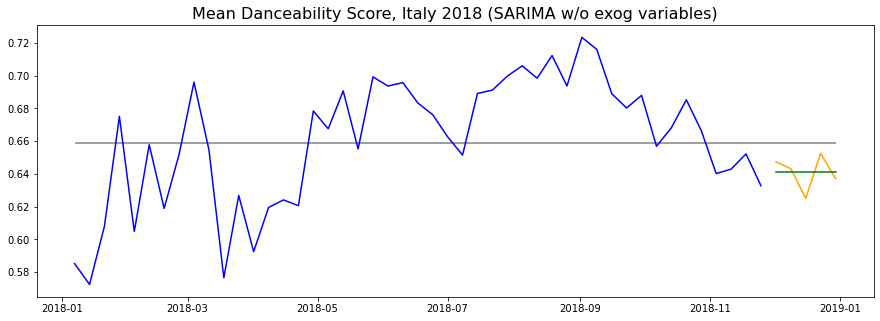

d = 1
order = (3, 1, 0)
seasonal order = (1, 0, 1, 52)
Mode train RMSE (2018) - SARIMA((3, 1, 0)): 0.05366373069312147
Mode test RMSE (2018) - SARIMA((3, 1, 0)): 0.05203894653955396


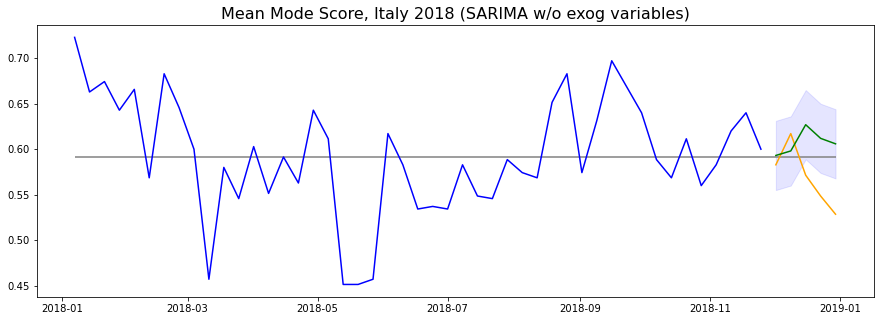

d = 1
order = (0, 1, 2)
seasonal order = (1, 0, 2, 48)
Acousticness train RMSE (2018) - SARIMA((0, 1, 2)): 0.036374265288011735
Acousticness test RMSE (2018) - SARIMA((0, 1, 2)): 0.060643236332092065


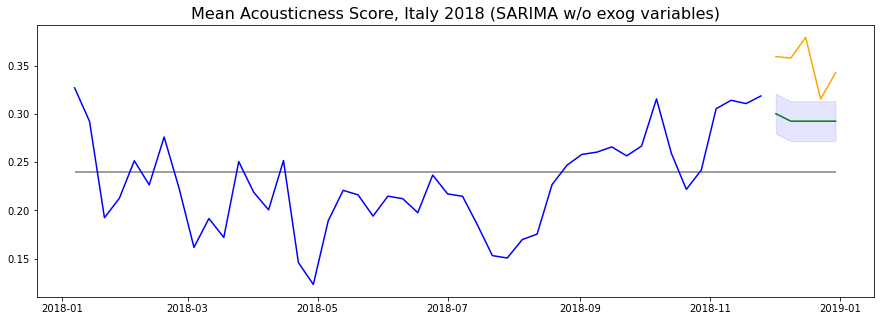

d = 1
order = (2, 1, 4)
seasonal order = (0, 0, 1, 49)
Valence train RMSE (2018) - SARIMA((2, 1, 4)): 0.03280168646918084
Valence test RMSE (2018) - SARIMA((2, 1, 4)): 0.031699263515060555


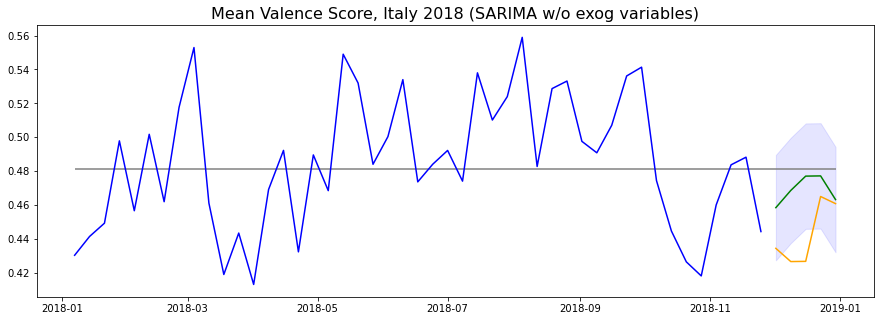

d = 1
order = (0, 1, 0)
seasonal order = (2, 0, 0, 49)
Energy train RMSE (2018) - SARIMA((0, 1, 0)): 0.02968483192964706
Energy test RMSE (2018) - SARIMA((0, 1, 0)): 0.021970019303059165


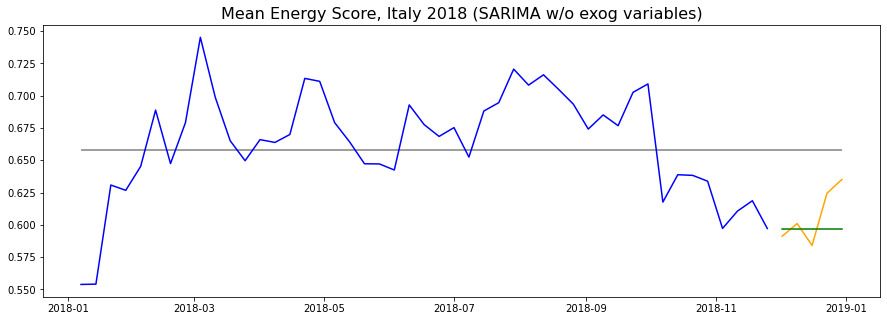

In [177]:
for feature in five_features:
    sarima_predict_plot_seasonal(it_rw_18, feature, 2018, arima_param_df_18, title=f'Mean {feature.capitalize()} Score, Italy 2018 (SARIMA w/o exog variables)')

#### _Updated `arima_param_df_18`_

In [178]:
arima_param_df_18

,audio_feature,ndiffs(d),best_p,best_q,order,ARIMA_model,ARIMA_AIC,arima_train_rmse,arima_test_rmse,seasonal_order,seasonal_order_all_data,sarima_train_rmse,sarima_test_rmse
0,danceability,1,0,1,"(0, 1, 1)","ARIMA(0,1,1)",-217.460539,0.028161,0.010787,"3, 0, 0, 48","2, 0, 3, 48",0.028236,0.009447
1,mode,1,3,0,"(3, 1, 0)","ARIMA(3,1,0)",-146.889516,0.053561,0.042752,"1, 0, 1, 52","0, 0, 0, 48",0.053664,0.052039
2,acousticness,1,0,2,"(0, 1, 2)","ARIMA(0,1,2)",-184.369110,0.036351,0.057268,"1, 0, 2, 48","0, 1, 0, 48",0.036374,0.060643
3,valence,1,2,4,"(2, 1, 4)","ARIMA(2,1,4)",-191.967291,0.036157,0.040172,"0, 0, 1, 49","1, 0, 3, 50",0.032802,0.031699
4,energy,1,0,0,"(0, 1, 0)","ARIMA(0,1,0)",-212.768422,0.029670,0.019848,"2, 0, 0, 49","0, 0, 2, 51",0.029685,0.021970


#### _Incorporating Exogenous Variables in SARIMAX models_

In [179]:
def sarima_predict_plot_exog(df, feature, year, param_df, exog_var, title='title', figsize=(15,5), order=None, d=None, seasonal_order=None, ci=True):

    # find ndiffs for stationarity from ndiff dataframe
    if d is None: 
        d = ndiff_df.loc[ndiff_df['audio_feature'] == feature, 'ndiffs for stationarity'].iloc[0]
    print(f'd = {d}')
    
    # find order from arima parameters dataframe 
    if order is None:
        order = param_df.loc[param_df['audio_feature'] == feature, 'order'].iloc[0]
    print(f'order = {order}')
    
    # find seasonal order from arima parameters dataframe 
    if seasonal_order is None: 
        sea_string = param_df.loc[param_df['audio_feature'] == feature, 'seasonal_order'].iloc[0]
        seasonal_order = tuple(map(int, sea_string.split(', '))) 
    print(f'seasonal order = {seasonal_order}')
    
    # reshape exogenous features to pass to the model 
    exog = df.loc[:, exog_var]   
   
    # create train and test sets
    n_rows = round(len(df)*0.9)
    train = df[feature][0:n_rows]
    test = df[feature][n_rows:]
  
    try:
        # instantiate and fit SARIMAX model 
        sarima = SARIMAX(endog=train, exog=exog[0:n_rows], order=order, seasonal_order=seasonal_order).fit()

        # get predictions for train and test sets 
        preds_train = sarima.predict(start=train.index[d], end=train.index[-1], typ='levels', exog=exog[0:n_rows])
        preds_test = sarima.predict(start=test.index[0], end=test.index[-1], typ='levels', exog=exog[n_rows:])

        # calculate and print RMSE for train and test setes 
        train_rmse = mean_squared_error(train[d::], preds_train)**0.5
        print(f'{feature.capitalize()} train RMSE ({year}) - SARIMAX({seasonal_order}) w/ exogenous variables: {train_rmse}')

        test_rmse = mean_squared_error(test, preds_test)**0.5
        print(f'{feature.capitalize()} test RMSE ({year}) - SARIMAX({seasonal_order}) w/ exogenous variables: {test_rmse}')    

        # add RMSEs to arima parameters dataframe 
        param_df.loc[param_df['audio_feature'] == feature, 'exog_train_rmse'] = train_rmse    
        param_df.loc[param_df['audio_feature'] == feature, 'exog_test_rmse'] = test_rmse

        # calculate residuals
        # residuals = test - preds_test

        # set up plot
        plt.figure(figsize=figsize)

        # plot training data 
        plt.plot(train, color='blue')

        # plot testing data 
        plt.plot(test.index, test, color='orange')

        # plot predicted values for test set 
        plt.plot(test.index, preds_test, color='green')

        # add line for the baseline model (mean value of feature)
        plt.hlines(df[feature].mean(), train.index[0], test.index[-1], color = 'grey')

        # plot confidence interval 
        if ci:
            ci = 1.96 * np.std(preds_test)/np.mean(preds_test)
            plt.fill_between(test.index, (preds_test - ci), (preds_test + ci), color='blue', alpha=.1) 

        # make plot with title! 
        plt.title(title, fontsize=16)
        plt.show() ; 
        
    except ValueError as ve:
        print(ve)
        pass

_Identifying exogenous variables for each of the five main features, which for each of them is the other four audio features_

In [180]:
five_features = ['danceability', 'mode', 'acousticness', 'valence', 'energy']

exog_danceability = ['mode', 'acousticness', 'valence', 'energy']
exog_mode = ['danceability', 'acousticness', 'valence', 'energy']
exog_acousticness = ['danceability', 'mode', 'valence', 'energy']
exog_valence = ['danceability', 'mode', 'acousticness', 'energy']
exog_energy = ['danceability', 'mode', 'acousticness', 'valence']

d = 1
order = (0, 1, 1)
seasonal order = (3, 0, 0, 48)
Danceability train RMSE (2018) - SARIMAX((3, 0, 0, 48)) w/ exogenous variables: 0.02091316533663842
Danceability test RMSE (2018) - SARIMAX((3, 0, 0, 48)) w/ exogenous variables: 0.015281311870195937


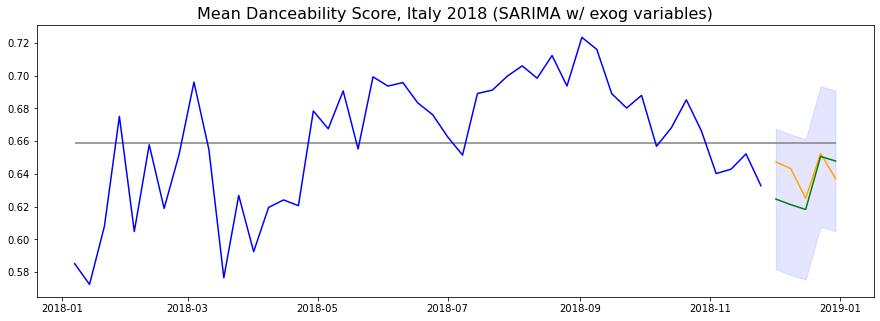

In [181]:
sarima_predict_plot_exog(it_rw_18, 'danceability', 2018, arima_param_df_18, exog_var=exog_danceability, title=f'Mean Danceability Score, Italy 2018 (SARIMA w/ exog variables)')

In [182]:
# for feature in five_features:
#     sarima_predict_plot_exog(it_rw_17, feature, 2017, exog_var=f'exog_{feature}', title=f'Mean {feature} Score, Italy 2017 (SARIMA w/ exog variables)')

d = 1
order = (3, 1, 0)
seasonal order = (1, 0, 1, 52)
Mode train RMSE (2018) - SARIMAX((1, 0, 1, 52)) w/ exogenous variables: 0.04925835575182797
Mode test RMSE (2018) - SARIMAX((1, 0, 1, 52)) w/ exogenous variables: 0.05909171909015656


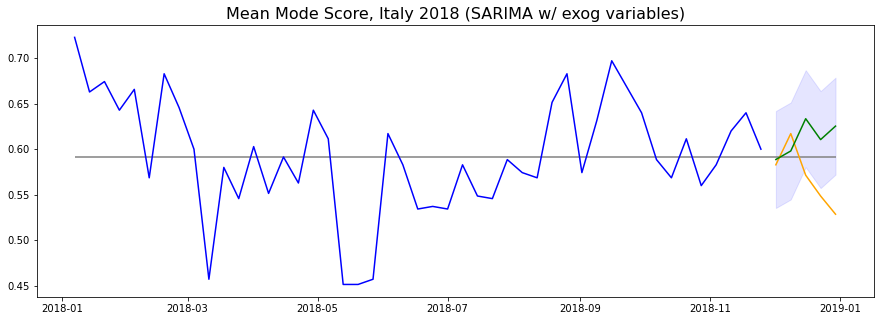

In [183]:
sarima_predict_plot_exog(it_rw_18, 'mode', 2018, arima_param_df_18, exog_var=exog_mode, title=f'Mean Mode Score, Italy 2018 (SARIMA w/ exog variables)')

d = 1
order = (0, 1, 2)
seasonal order = (1, 0, 2, 48)
Acousticness train RMSE (2018) - SARIMAX((1, 0, 2, 48)) w/ exogenous variables: 0.024982227567524332
Acousticness test RMSE (2018) - SARIMAX((1, 0, 2, 48)) w/ exogenous variables: 0.0562435566116608


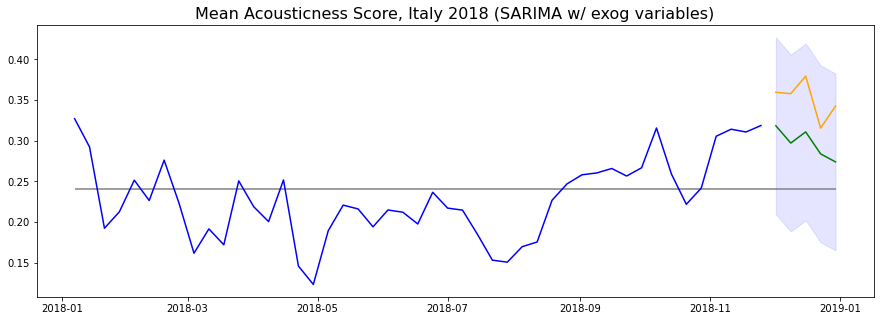

In [184]:
sarima_predict_plot_exog(it_rw_18, 'acousticness', 2018, arima_param_df_18, exog_var=exog_acousticness, title=f'Mean Acousticness Score, Italy 2018 (SARIMA w/ exog variables)')

d = 1
order = (2, 1, 4)
seasonal order = (0, 0, 1, 49)
Valence train RMSE (2018) - SARIMAX((0, 0, 1, 49)) w/ exogenous variables: 0.023915990129439048
Valence test RMSE (2018) - SARIMAX((0, 0, 1, 49)) w/ exogenous variables: 0.02585441686508716


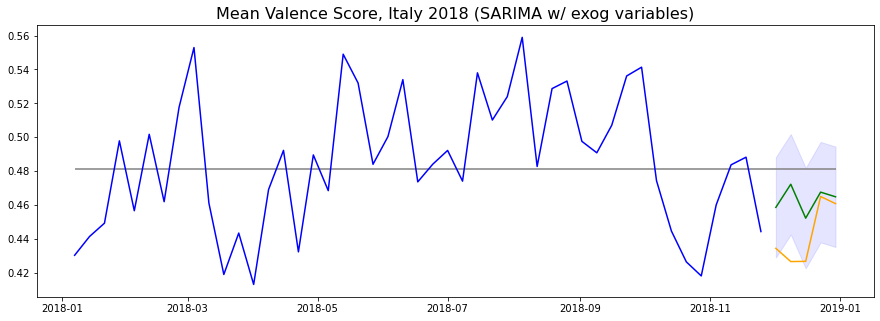

In [185]:
sarima_predict_plot_exog(it_rw_18, 'valence', 2018, arima_param_df_18, exog_var=exog_valence, title=f'Mean Valence Score, Italy 2018 (SARIMA w/ exog variables)')

d = 1
order = (0, 1, 0)
seasonal order = (2, 0, 0, 49)
Energy train RMSE (2018) - SARIMAX((2, 0, 0, 49)) w/ exogenous variables: 0.01874643419635838
Energy test RMSE (2018) - SARIMAX((2, 0, 0, 49)) w/ exogenous variables: 0.02832886483129452


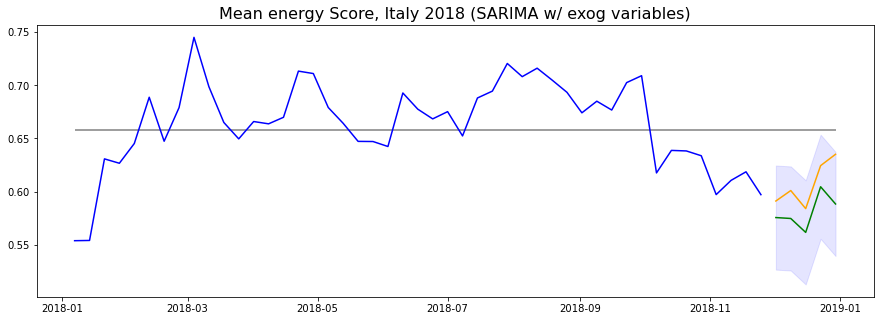

In [186]:
sarima_predict_plot_exog(it_rw_18, 'energy', 2018, arima_param_df_18, exog_var=exog_energy, title=f'Mean energy Score, Italy 2018 (SARIMA w/ exog variables)')

#### _Updated `arima_param_df_18`_

In [190]:
arima_param_df_18

,audio_feature,ndiffs(d),best_p,best_q,order,ARIMA_model,ARIMA_AIC,arima_train_rmse,arima_test_rmse,seasonal_order,seasonal_order_all_data,sarima_train_rmse,sarima_test_rmse,exog_train_rmse,exog_test_rmse
0,danceability,1,0,1,"(0, 1, 1)","ARIMA(0,1,1)",-217.460539,0.028161,0.010787,"3, 0, 0, 48","2, 0, 3, 48",0.028236,0.009447,0.020913,0.015281
1,mode,1,3,0,"(3, 1, 0)","ARIMA(3,1,0)",-146.889516,0.053561,0.042752,"1, 0, 1, 52","0, 0, 0, 48",0.053664,0.052039,0.049258,0.059092
2,acousticness,1,0,2,"(0, 1, 2)","ARIMA(0,1,2)",-184.369110,0.036351,0.057268,"1, 0, 2, 48","0, 1, 0, 48",0.036374,0.060643,0.024982,0.056244
3,valence,1,2,4,"(2, 1, 4)","ARIMA(2,1,4)",-191.967291,0.036157,0.040172,"0, 0, 1, 49","1, 0, 3, 50",0.032802,0.031699,0.023916,0.025854
4,energy,1,0,0,"(0, 1, 0)","ARIMA(0,1,0)",-212.768422,0.029670,0.019848,"2, 0, 0, 49","0, 0, 2, 51",0.029685,0.021970,0.018746,0.028329


#### _Pickling 2018 `arima_param_df_18` to compare with other years in another notebook_

In [192]:
arima_param_df_18.to_pickle('./metrics/2018_sarima_param_df.pkl')

In [191]:
five_features 

['danceability', 'mode', 'acousticness', 'valence', 'energy']